In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3090


# Model Config

In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms

import os
import json
from time import perf_counter
import random

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
torch.set_printoptions(precision=4, sci_mode=False)

In [4]:
torch.set_grad_enabled(False)

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [6]:
# import ipywidgets as widgets

# model_widget = widgets.Dropdown(
#     options=["vgg16", "resnet18", "efficientnet_b4", "convnext_base"],
#     value="vgg16",
#     description="Model:",
#     disabled=False,
# )
# model_widget

In [7]:
# model_widget.value

In [8]:
DEVICE, DTYPE = (
    torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    torch.float32,
)
MODEL_NAME = "vgg16"
INPUT_PATH = "img/imagenet_filtered/"
OUTPUT_ROOT = "outputs_test"
OUTPUT_PATH = f"{OUTPUT_ROOT}/{MODEL_NAME}"
OUTPUT_PATH_DEBUG = f"{OUTPUT_PATH}/debug"

labels_path = "models/imagenet_class_index.json"

os.makedirs(OUTPUT_PATH_DEBUG, exist_ok=True)

model = getattr(models, MODEL_NAME)(weights="DEFAULT").to(device=DEVICE, dtype=DTYPE)
model = nn.Sequential(
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    model,
    nn.Softmax(dim=1),
)
model.eval()

# Obtain the last convolutional layer
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        last_conv_layer = layer

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.to(device=DEVICE, dtype=DTYPE)),
    ]
)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Model {type(model).__name__} total parameters: ", pytorch_total_params)

with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

get_class = lambda id: idx_to_labels[str(id)][0]
get_label = lambda id: idx_to_labels[str(id)][1]

load_image = lambda img_source, transform: transform(Image.open(img_source))

inputs = []
for filename in sorted(os.listdir(INPUT_PATH)):
    f = os.path.join(INPUT_PATH, filename)
    image = load_image(f, transform)
    if image.shape[0] == 1:  # do not support grayscale images
        continue
    inputs.append(image)
inputs = torch.stack(inputs, dim=0)
inputs.shape

Model Sequential total parameters:  138357544


torch.Size([48, 3, 224, 224])

In [9]:
inputs = inputs[:4]
inputs.shape

torch.Size([4, 3, 224, 224])

In [10]:
with torch.no_grad():
    output = model(inputs)
prediction_score, pred_label_idx = map(lambda x: x.squeeze_(), torch.topk(output, 1))

for score, label_idx in zip(prediction_score, pred_label_idx):
    id = label_idx.item()
    predicted_label = get_label(id)
    print(f"Predicted: {predicted_label} ({id}) ({score.item():.4f})")

Predicted: Scotch_terrier (199) (0.9993)
Predicted: solar_dish (807) (0.9999)
Predicted: leafhopper (317) (0.9996)
Predicted: trilobite (69) (1.0000)


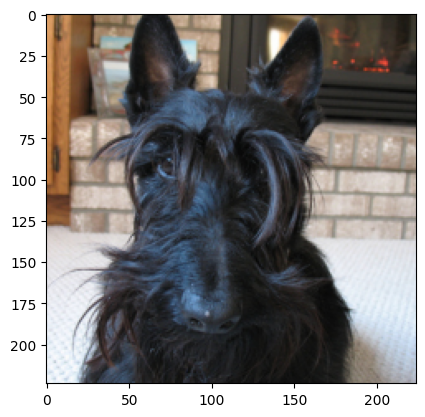

In [11]:
plt.imshow(inputs[0].permute(1, 2, 0).detach().cpu().numpy())

# Attributions

In [12]:
# model

In [13]:
# match MODEL_NAME:
#     case "resnet18":
#         last_conv_layer = model[1].layer4[-1]
#     case "vgg16":
#         last_conv_layer = model[1].features[-1]
#     case _:
#         raise ValueError(f"Model {MODEL_NAME} not supported")

In [14]:
force_computation = True

In [15]:
from utils.model_analyzer import ModelAnalyzer, HeatmapUtils
from utils.attr_config import AttributionConfig
from captum.attr import Occlusion, LayerGradCam
from rise.rise import RISE

analyzer = ModelAnalyzer(model, inputs)
analyzer.forward_pass(idx_to_labels)

# conv_layers = ModelAnalyzer.find_layers_by_type(model, nn.Conv2d)
# last_conv_layer = conv_layers[-1]

rise_config = AttributionConfig(
    RISE,
    n_masks=4096,
    initial_mask_shapes=((4, 4),),
    blur_sigma=10.0,
    threshold=0.3,
    patience=64,
    d_epsilon=1e-3,
    show_progress=True,
)

occlusion_config = AttributionConfig(
    attribution_class=Occlusion,
    sliding_window_shapes=(3, 32, 32),
    strides=(3, 16, 16),
    baselines=0,
    callback=lambda x: torch.clamp(x, min=0)[:, :1, :],
    show_progress=True,
)
# x.abs().mean(1, keepdim=True),

gradcam_config = AttributionConfig(
    LayerGradCam,
    layer=last_conv_layer,
    relu_attributions=True,
)

try:
    if force_computation:
        raise FileNotFoundError
    heatmap_rise = torch.load(f"{OUTPUT_PATH}/heatmap_rise.pt", map_location=DEVICE)
    heatmap_occ = torch.load(f"{OUTPUT_PATH}/heatmap_occ.pt", map_location=DEVICE)
    heatmap_gc = torch.load(f"{OUTPUT_PATH}/heatmap_gc.pt", map_location=DEVICE)
    activations = torch.load(f"{OUTPUT_PATH}/activations.pt", map_location=DEVICE)
except:
    heatmap_rise = analyzer.analyze(rise_config)
    heatmap_occ = analyzer.analyze(occlusion_config)
    heatmap_gc = analyzer.analyze(gradcam_config)
    activations = analyzer.get_activations(last_conv_layer, pool=True)

torch.save(heatmap_rise, f"{OUTPUT_PATH}/heatmap_rise.pt")
torch.save(heatmap_occ, f"{OUTPUT_PATH}/heatmap_occ.pt")
torch.save(heatmap_gc, f"{OUTPUT_PATH}/heatmap_gc.pt")
torch.save(activations, f"{OUTPUT_PATH}/activations.pt")

R I S E mask ((4, 4),):   0%|          | 0/4096 [00:00<?, ?it/s]

Occlusion attribution:   0%|          | 0/170 [00:00<?, ?it/s]

In [16]:
analyzer.predictions

[{'id': 199, 'label': 'Scotch_terrier', 'score': 0.9992777705192566},
 {'id': 807, 'label': 'solar_dish', 'score': 0.9999068975448608},
 {'id': 317, 'label': 'leafhopper', 'score': 0.9996312856674194},
 {'id': 69, 'label': 'trilobite', 'score': 0.9999645948410034}]

In [17]:
# from captum.attr import visualization as viz

In [18]:
# _ = viz.visualize_image_attr(
#     heatmap_rise[0].permute(1, 2, 0).detach().cpu().numpy(),
#     method="heat_map",
#     sign="absolute_value",
#     cmap="jet",
#     show_colorbar=True,
# )

In [19]:
# _ = viz.visualize_image_attr(
#     heatmap_occ[0].permute(1, 2, 0).detach().cpu().numpy(),
#     method="heat_map",
#     sign="positive",
#     cmap="jet",
#     show_colorbar=True,
# )

In [20]:
# _ = viz.visualize_image_attr(
#     heatmap_gc[0].permute(1, 2, 0).detach().cpu().numpy(),
#     method="heat_map",
#     sign="positive",
#     cmap="jet",
#     show_colorbar=True,
# )

In [21]:
# _ = viz.visualize_image_attr(
#     activations[0].permute(1, 2, 0).detach().cpu().numpy(),
#     method="heat_map",
#     sign="positive",
#     cmap="jet",
#     show_colorbar=True,
# )

In [22]:
heatmap_rise.shape, heatmap_occ.shape, heatmap_gc.shape, activations.shape

(torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 14, 14]),
 torch.Size([4, 1, 14, 14]))

In [23]:
upsample_shape = inputs.shape[-2:]
upsample_mode = "bicubic"

heatmap_rise = HeatmapUtils.upsample(heatmap_rise, upsample_shape, upsample_mode)
heatmap_occ = HeatmapUtils.upsample(heatmap_occ, upsample_shape, upsample_mode)
heatmap_gc = HeatmapUtils.upsample(heatmap_gc, upsample_shape, upsample_mode)
activations = HeatmapUtils.upsample(activations, upsample_shape, upsample_mode)

In [24]:
heatmap_rise.shape, heatmap_occ.shape, heatmap_gc.shape, activations.shape

(torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 224, 224]),
 torch.Size([4, 1, 224, 224]))

In [25]:
(
    heatmap_rise.amin(dim=(1, 2, 3)),
    heatmap_rise.amax(dim=(1, 2, 3)),
    heatmap_occ.amin(dim=(1, 2, 3)),
    heatmap_occ.amax(dim=(1, 2, 3)),
    heatmap_gc.amin(dim=(1, 2, 3)),
    heatmap_gc.amax(dim=(1, 2, 3)),
    activations.amin(dim=(1, 2, 3)),
    activations.amax(dim=(1, 2, 3)),
)

(tensor([0.2081, 0.2218, 0.2103, 0.1685], device='cuda:0'),
 tensor([0.2237, 0.2305, 0.2234, 0.2140], device='cuda:0'),
 tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([0.0078, 0.0003, 0.0043, 0.0028], device='cuda:0'),
 tensor([    -0.0000,     -0.0000,     -0.0000,     -0.0000], device='cuda:0'),
 tensor([    0.0000,     0.0000,     0.0000,     0.0000], device='cuda:0'),
 tensor([0.0299, 0.0150, 0.0649, 0.0086], device='cuda:0'),
 tensor([0.8722, 0.3895, 0.4177, 0.4008], device='cuda:0'))

In [26]:
heatmap_rise = HeatmapUtils.normalize(heatmap_rise)
heatmap_occ = HeatmapUtils.normalize(heatmap_occ)
heatmap_gc = HeatmapUtils.normalize(heatmap_gc)
activations = HeatmapUtils.normalize(activations)

In [27]:
(
    heatmap_rise.amin(dim=(1, 2, 3)),
    heatmap_rise.amax(dim=(1, 2, 3)),
    heatmap_occ.amin(dim=(1, 2, 3)),
    heatmap_occ.amax(dim=(1, 2, 3)),
    heatmap_gc.amin(dim=(1, 2, 3)),
    heatmap_gc.amax(dim=(1, 2, 3)),
    activations.amin(dim=(1, 2, 3)),
    activations.amax(dim=(1, 2, 3)),
)

(tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
 tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
 tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([0.9998, 0.9981, 0.9995, 0.9957], device='cuda:0'),
 tensor([0., 0., 0., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1.], device='cuda:0'))

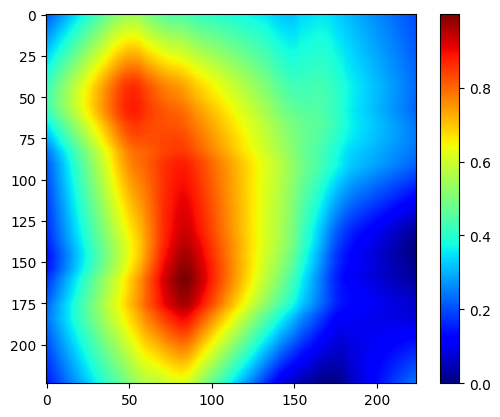

In [28]:
plt.imshow(heatmap_rise[0].permute(1, 2, 0).detach().cpu().numpy(), cmap="jet")
plt.colorbar()

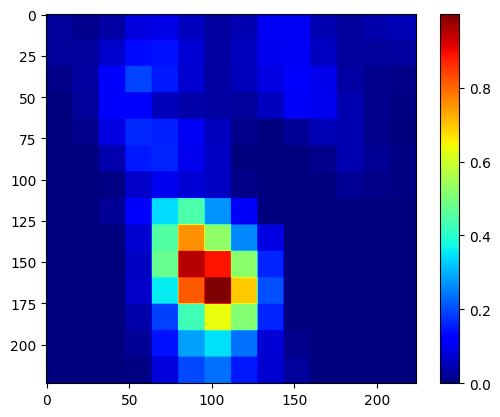

In [29]:
plt.imshow(heatmap_occ[0].permute(1, 2, 0).detach().cpu().numpy(), cmap="jet")
plt.colorbar()

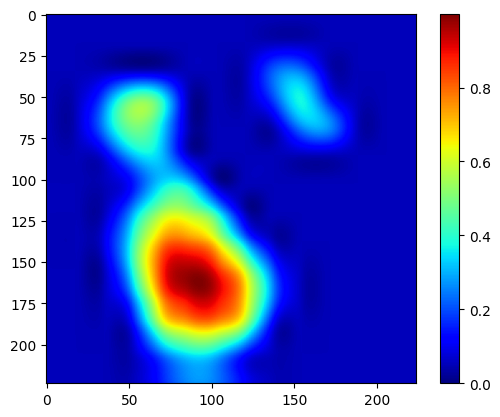

In [30]:
plt.imshow(heatmap_gc[0].permute(1, 2, 0).detach().cpu().numpy(), cmap="jet")
plt.colorbar()

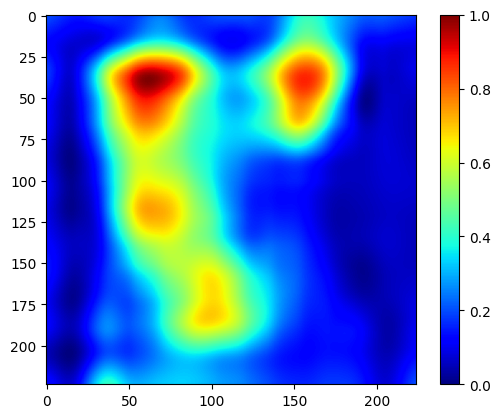

In [31]:
plt.imshow(activations[0].permute(1, 2, 0).detach().cpu().numpy(), cmap="jet")
plt.colorbar()

# Pixel Score

In [32]:
from IPython.display import HTML
from base64 import b64encode

from utils.video import VideoCallback
from pixel_score.pixel_score import PixelScore

In [33]:
SCORE_MODE = "erosion"
SCORE_THRESHOLD = 0.5
SCORE_KWARGS = {"blur_sigma": 10.0}
overlay_image = True

In [34]:
# heatmap_rise
vc = VideoCallback(cmap="gray")
metric = PixelScore(
    model, inputs, heatmap_rise, analyzer.targets, analyzer.scores, **SCORE_KWARGS
)
metric.update(
    "erode",
    target_fraction=0.01,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_erosion_curve_rise, ps_erosion_auc_rise = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_rise_erosion.mp4")
metric.reset()
vc.reset()
metric.update(
    "dilate",
    target_fraction=0.95,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_dilation_curve_rise, ps_dilation_auc_rise = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_rise_dilation.mp4")

In [35]:
mp4 = open(f"{OUTPUT_PATH_DEBUG}/heatmap_rise_erosion.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(
    """
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """
    % data_url
)

In [36]:
# ps_erosion_curve_rise, ps_erosion_auc_rise

In [37]:
# heatmap_occ
vc = VideoCallback(cmap="gray")
metric = PixelScore(
    model, inputs, heatmap_occ, analyzer.targets, analyzer.scores, **SCORE_KWARGS
)
metric.update(
    "erode",
    target_fraction=0.01,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_erosion_curve_occ, ps_erosion_auc_occ = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_occ_erosion.mp4")
metric.reset()
vc.reset()
metric.update(
    "dilate",
    target_fraction=0.95,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_dilation_curve_occ, ps_dilation_auc_occ = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_occ_dilation.mp4")

In [38]:
mp4 = open(f"{OUTPUT_PATH_DEBUG}/heatmap_occ_erosion.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(
    """
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """
    % data_url
)

In [39]:
# ps_erosion_curve_occ, ps_erosion_auc_occ

In [40]:
# heatmap_gc
vc = VideoCallback(cmap="gray")
metric = PixelScore(
    model, inputs, heatmap_gc, analyzer.targets, analyzer.scores, **SCORE_KWARGS
)
metric.update(
    "erode",
    target_fraction=0.01,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_erosion_curve_gc, ps_erosion_auc_gc = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_gc_erosion.mp4")
metric.reset()
vc.reset()
metric.update(
    "dilate",
    target_fraction=0.95,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_dilation_curve_gc, ps_dilation_auc_gc = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/heatmap_gc_dilation.mp4")

In [41]:
mp4 = open(f"{OUTPUT_PATH_DEBUG}/heatmap_gc_erosion.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(
    """
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """
    % data_url
)

In [42]:
# ps_erosion_curve_gc, ps_erosion_auc_gc

In [43]:
# activations
vc = VideoCallback(cmap="gray")
metric = PixelScore(
    model, inputs, activations, analyzer.targets, analyzer.scores, **SCORE_KWARGS
)
metric.update(
    "erode",
    target_fraction=0.01,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_erosion_curve_act, ps_erosion_auc_act = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/activations_erosion.mp4")
metric.reset()
vc.reset()
metric.update(
    "dilate",
    target_fraction=0.95,
    threshold=SCORE_THRESHOLD,
    max_iter=100,
    callbacks=[vc],
)
ps_dilation_curve_act, ps_dilation_auc_act = metric.output_curves, metric.compute()
vc.save_video(f"{OUTPUT_PATH_DEBUG}/activations_dilation.mp4")

In [44]:
mp4 = open(f"{OUTPUT_PATH_DEBUG}/activations_erosion.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(
    """
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """
    % data_url
)

In [45]:
# ps_erosion_curve_act, ps_dilation_curve_act

# Plots

In [46]:
from matplotlib import ticker as tkr

In [47]:
def get_score_value(mode, erosion_value, dilation_value):
    return erosion_value if mode == "erosion" else dilation_value


def set_figsize(fig, n_rows, n_columns, width_per_column=1.2, height_per_row=1.2):
    width = n_columns * width_per_column
    height = n_rows * height_per_row
    fig.set_size_inches(width, height)


def plot_curve(ax, curve_data, auc_value, is_dilation=False):
    # Convertir a numpy y ordenar
    xy = curve_data.cpu().numpy()
    sorted_indices = np.argsort(xy[:, 0])
    x = xy[sorted_indices, 0]
    y = xy[sorted_indices, 1]

    # Filtrar valores de padding (1.0) manteniendo el último punto válido
    valid_mask = x < 1.0
    first_false_index = np.argmax(~valid_mask)
    valid_mask[first_false_index] = True  # Keep 1.0 accuracy
    if np.any(valid_mask):
        x = x[valid_mask]
        y = y[valid_mask]

    ax.plot(x, y, color="tab:blue", linewidth=1)
    ax.fill_between(x, y, alpha=0.3, color="tab:blue")

    ax.tick_params(labelsize=6)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter("%.2f"))

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)

    try:
        if not is_dilation:
            ax.invert_xaxis()
            ax.axvline(x[-2], color="r", linestyle="--", linewidth=1)
        else:
            ax.set_xticks([0.0, x[0], 0.5, 1.0])
            ax.xaxis.set_major_formatter(tkr.FormatStrFormatter("%.2f"))
    except IndexError:
        pass

    ax.text(
        0.40,
        0.80,
        f"AUC: {auc_value:.2f}",
        transform=ax.transAxes,
        fontsize=7,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )

/tmp/ipykernel_185830/3147309689.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.75, wspace=0.5)


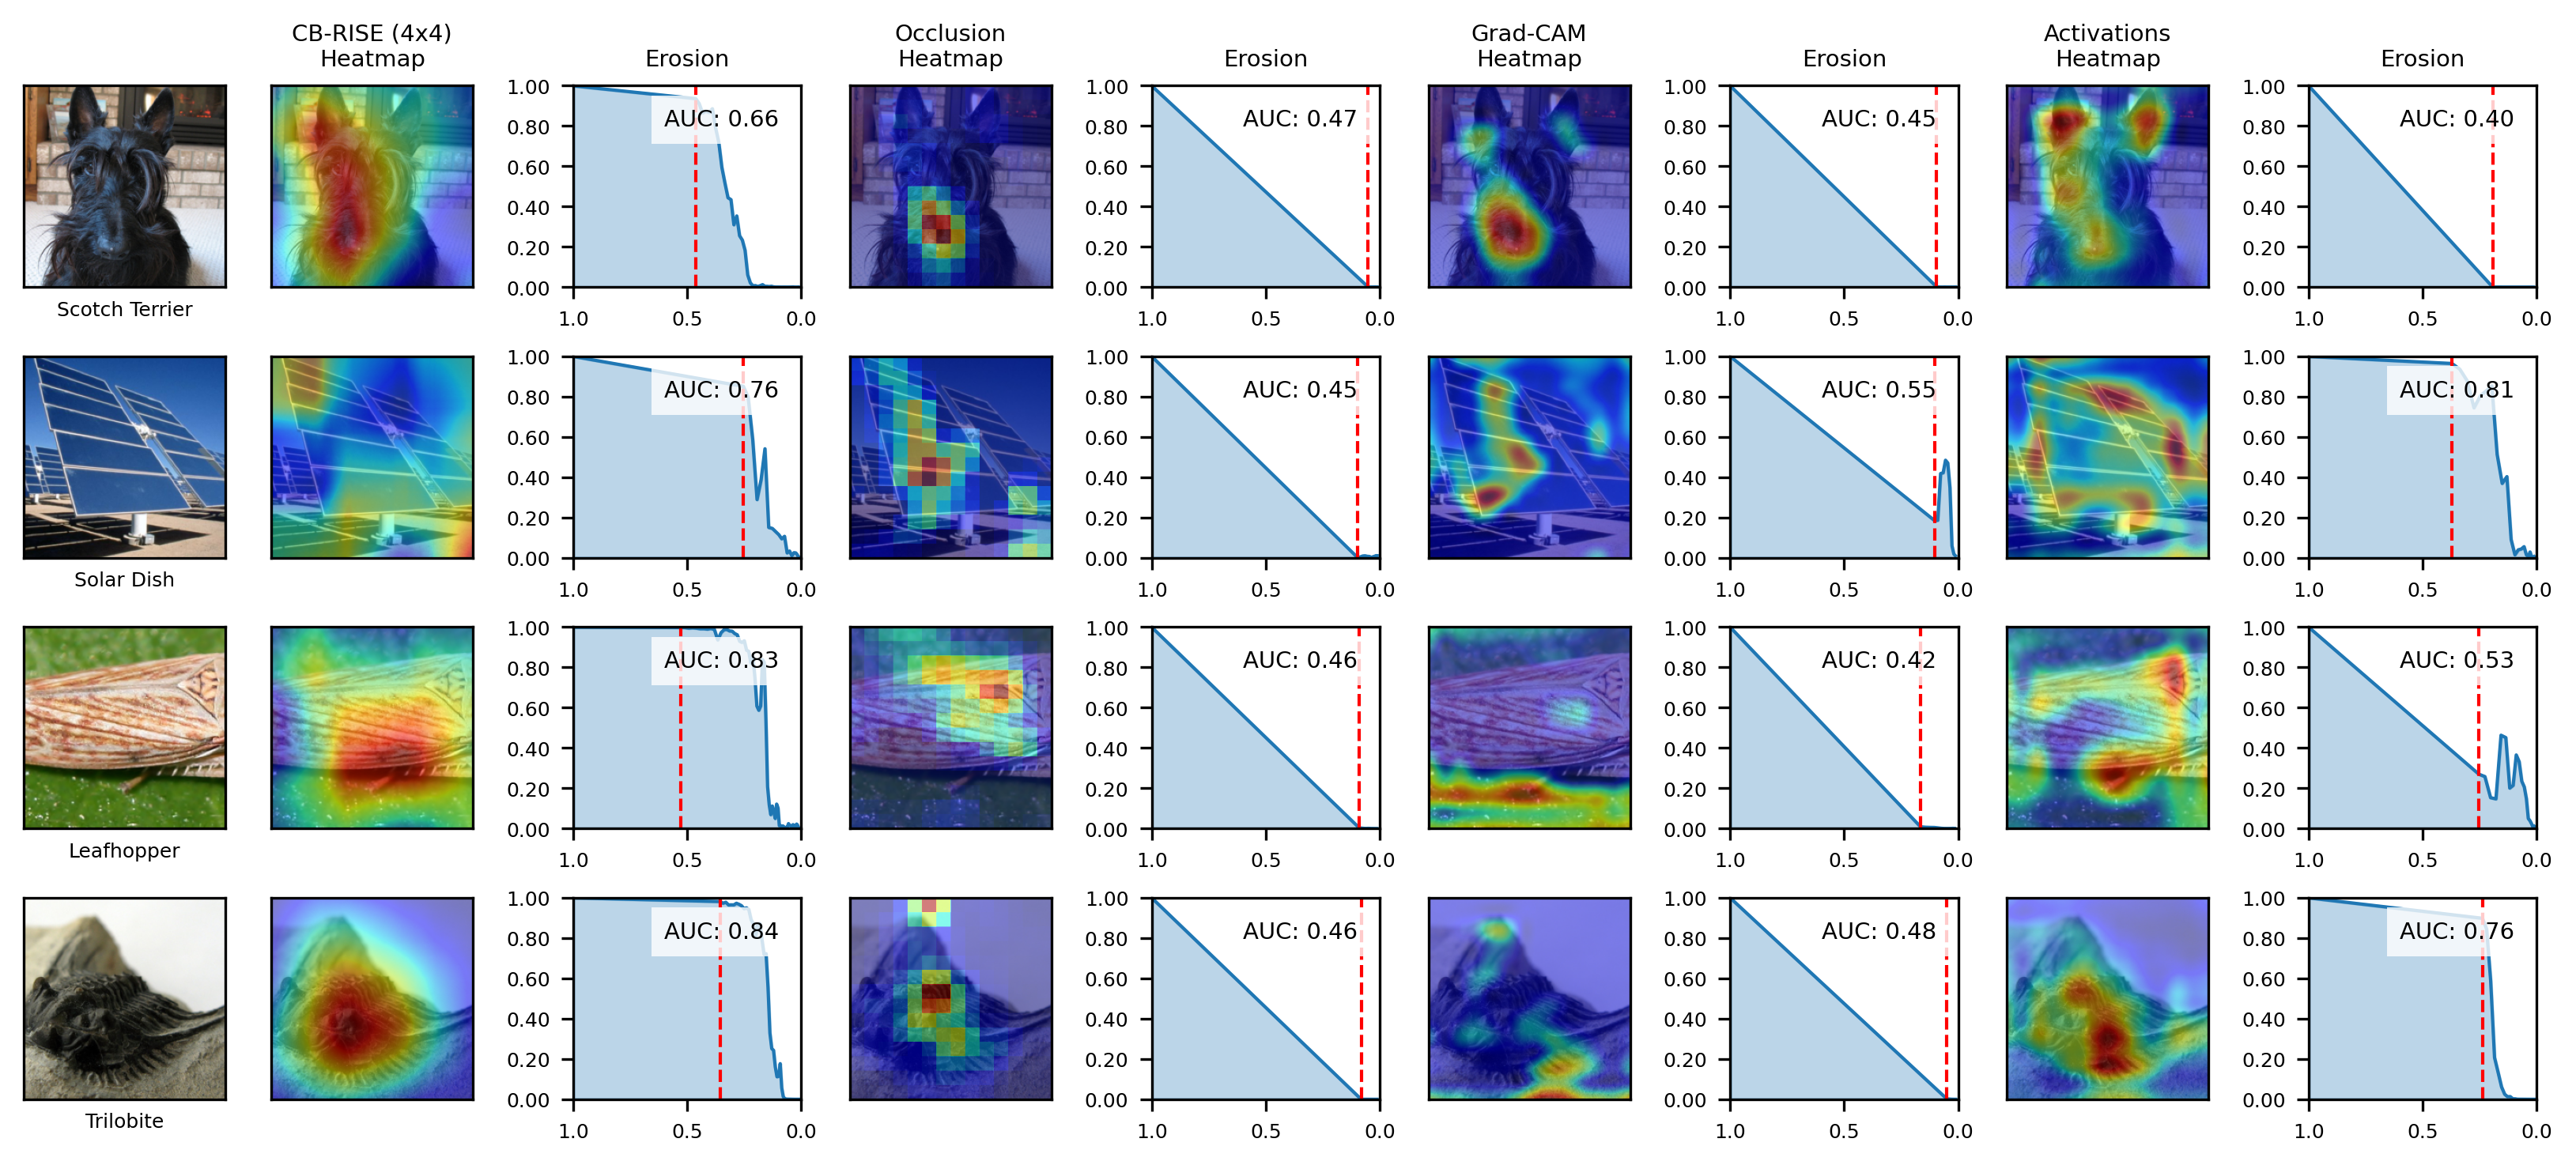

In [48]:
attributions = [
    (
        heatmap_rise,
        get_score_value(SCORE_MODE, ps_erosion_curve_rise, ps_dilation_curve_rise),
        get_score_value(SCORE_MODE, ps_erosion_auc_rise, ps_dilation_auc_rise),
    ),
    (
        heatmap_occ,
        get_score_value(SCORE_MODE, ps_erosion_curve_occ, ps_dilation_curve_occ),
        get_score_value(SCORE_MODE, ps_erosion_auc_occ, ps_dilation_auc_occ),
    ),
    (
        heatmap_gc,
        get_score_value(SCORE_MODE, ps_erosion_curve_gc, ps_dilation_curve_gc),
        get_score_value(SCORE_MODE, ps_erosion_auc_gc, ps_dilation_auc_gc),
    ),
    (
        activations,
        get_score_value(SCORE_MODE, ps_erosion_curve_act, ps_dilation_curve_act),
        get_score_value(SCORE_MODE, ps_erosion_auc_act, ps_dilation_auc_act),
    ),
]

cols = ["CB-RISE (4x4)", "Occlusion", "Grad-CAM", "Activations"]

fig, axes = plt.subplots(
    inputs.shape[0], len(attributions) * 2 + 1, constrained_layout=True
)
set_figsize(fig, inputs.shape[0], len(attributions) * 2 + 1)
fig.set_dpi(300)
fig.subplots_adjust(hspace=0.75, wspace=0.5)

for i in range(inputs.shape[0]):
    image_np = inputs[i].permute(1, 2, 0).detach().cpu().numpy()
    axes[i, 0].imshow(image_np)
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 0].set_xlabel(
        f"{analyzer.predictions[i]['label'].replace('_', ' ').title()}", fontsize=6
    )

    for j, (attr, curve, auc) in enumerate(attributions):
        col_idx = j * 2 + 1

        if overlay_image:
            axes[i, col_idx].imshow(image_np)
        im = axes[i, col_idx].imshow(
            attr[i][0].detach().cpu().numpy(),
            cmap="jet",
            alpha=0.5 if overlay_image else 1,
        )
        # axes[i, col_idx].axis("off")
        axes[i, col_idx].set_xticks([])
        axes[i, col_idx].set_yticks([])

        plot_curve(
            axes[i, col_idx + 1],
            curve[i],
            auc[i].item(),
            is_dilation=SCORE_MODE == "dilation",
        )

        if i == 0:
            axes[0, col_idx].set_title(f"{cols[j]}\nHeatmap", fontsize=7)
            axes[0, col_idx + 1].set_title(SCORE_MODE.title(), fontsize=7)

plt.savefig(
    f"{OUTPUT_PATH}/attributions_scores_{SCORE_MODE}_{len(inputs)}.jpg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [49]:
for col, (_, _, auc) in zip(cols, attributions):
    print(
        f"{col}: {auc.mean().item()}",
        file=open(f"{OUTPUT_PATH}/auc_scores_avg_{SCORE_MODE}_{len(inputs)}.txt", "a"),
    )

In [50]:
import pickle

with open(
    f"{OUTPUT_PATH}/attributions_scores_{SCORE_MODE}_{len(inputs)}.pkl", "wb"
) as f:
    pickle.dump(
        {
            "inputs": inputs,
            "attributions": attributions,
            "predictions": analyzer.predictions,
        },
        f,
    )

In [51]:
with open(
    f"{OUTPUT_PATH}/attributions_scores_{SCORE_MODE}_{len(inputs)}.pkl", "rb"
) as f:
    data = pickle.load(f)
    inputs = data["inputs"]
    attributions = data["attributions"]
    predictions = data["predictions"]

/home/ostanchi/miniconda3/envs/captum/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [52]:
ps_erosion_curve_rise

tensor([[[    0.0130,     0.0005],
         [    0.0167,     0.0002],
         [    0.0208,     0.0001],
         [    0.0253,     0.0001],
         [    0.0302,     0.0003],
         [    0.0354,     0.0010],
         [    0.0410,     0.0006],
         [    0.0470,     0.0004],
         [    0.0532,     0.0002],
         [    0.0598,     0.0001],
         [    0.0666,     0.0001],
         [    0.0737,     0.0003],
         [    0.0811,     0.0002],
         [    0.0887,     0.0001],
         [    0.0966,     0.0004],
         [    0.1048,     0.0004],
         [    0.1132,     0.0005],
         [    0.1219,     0.0016],
         [    0.1309,     0.0043],
         [    0.1401,     0.0027],
         [    0.1497,     0.0039],
         [    0.1595,     0.0040],
         [    0.1696,     0.0123],
         [    0.1800,     0.0071],
         [    0.1905,     0.0034],
         [    0.2012,     0.0076],
         [    0.2122,     0.0065],
         [    0.2234,     0.0213],
         [    0.2349